In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import shap
import pickle
import os
import math

## sklearn

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer, confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import permutation_importance
from scipy.stats import skew, kurtosis
from sklearn.base import BaseEstimator, ClassifierMixin

## Models

In [3]:
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.svm import SVC

# Load CSVs

In [4]:
control_df = pd.read_csv("../Dataset/train_radiomics_occipital_CONTROL.csv")
train_df = pd.read_csv("../Dataset/train_radiomics_hipocamp.csv")
test_df = pd.read_csv("../Dataset/test_radiomics_hipocamp.csv")
dummy_df = pd.read_csv("../Dataset/dummy_submission.csv")

# Save & Load Data

In [5]:
uni_path = "../DataSaver/"

def save_stuff(data,path):
    file_path = os.path.join(uni_path, path)
    
    with open(file_path,"wb") as file:
        pickle.dump(data,file)

def load_stuff(path):
    file_path = os.path.join(uni_path,path)

    with open(file_path,"rb") as file:
        data = pickle.load(file)

    return data

# Data Exploration

## Category Encoder and Decoder

In [6]:
def target_encoder(df, target="Transition"):
    le_make = LabelEncoder()
    df[f"{target}_code"] = le_make.fit_transform(df[target])
    return le_make

def target_decoder(le_make, preds):
    return le_make.inverse_transform(preds)


In [7]:
le_make_train = target_encoder(train_df)
le_make_control = target_encoder(control_df)

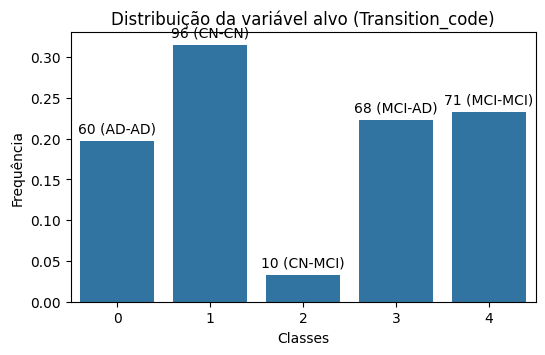

In [8]:
# Obtenção da distribuição e contagem de cada classe
target_distribution = train_df['Transition_code'].value_counts(normalize=True).sort_index()
target_counts = train_df['Transition_code'].value_counts().sort_index()

plt.figure(figsize=(6, 3.5))
ax = sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title("Distribuição da variável alvo (Transition_code)")
plt.xlabel("Classes")
plt.ylabel("Frequência")

le_make = target_encoder(train_df) 
decoded_labels = le_make.inverse_transform(target_distribution.index)

for index, value in enumerate(target_distribution.index):
    ax.text(index, target_distribution[value] + 0.01, f'{target_counts[value]} ({decoded_labels[index]})', ha='center')

plt.show()

## MatPlots

In [9]:
def show_histogram(df,title="histogram"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    plt.title(title)
    sns.histplot(df)
    plt.show()

In [10]:
def show_pie(df,title="pie"):
    labels = df.unique().tolist()
    counts = df.value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    _, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct="%1.1f%%",shadow=True)
    ax1.axis("equal")
    plt.title(title)
    plt.show()

In [11]:
def show_boxplot(df,title="boxplot"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    df.boxplot()
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()


In [12]:
def show_heatmap(df,title="correlation heatmap"):
    df = df.select_dtypes(include="number")
    plt.figure(figsize=(6,3.5))
    plt.subplots_adjust(bottom=0.25,left=0.22,right=0.95)
    plt.xticks(rotation=15)
    plt.title(title)
    sns.heatmap(df.corr(),annot=True,cmap="coolwarm",linewidths=0.5)
    plt.show()

In [13]:
def show_jointplot(df,x_label,y_label,title="jointplot",hue="Transition_code"):
    sns.jointplot(data=df,x=x_label,y=y_label,hue=hue)
    plt.show()

In [14]:
def show_catplot(df, x_label, y_label, title="catplot", hue="Transition_code", height=3, aspect=1.5):
    sns.catplot(data=df, x=x_label, y=y_label, hue=hue, height=height, aspect=aspect)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [15]:
def show_pairplot(df,hue="Transition_code"):
    sns.pairplot(df,hue=hue)
    plt.show()

## Basic Exploration

In [16]:
def main_exploration(df):
    print(df.shape) 

In [17]:
def numerical_exploration(df):
    # age exploration
    show_histogram(df["Age"],title="Histogram")
    print(df["Age"].describe())

In [18]:
train_df.describe()

,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,...,lbp-3D-k_glszm_ZonePercentage,lbp-3D-k_glszm_ZoneVariance,lbp-3D-k_ngtdm_Busyness,lbp-3D-k_ngtdm_Coarseness,lbp-3D-k_ngtdm_Complexity,lbp-3D-k_ngtdm_Contrast,lbp-3D-k_ngtdm_Strength,Sex,Age,Transition_code
count,305.0,305.000000,305.0,305.000000,305.000000,305.0,305.000000,305.000000,305.000000,305.000000,...,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,3.0,5.810469,0.0,173.504918,6714.790164,2.0,0.411819,0.096916,10.137707,104.883349,...,0.010477,266015.006289,362.064990,0.002024,0.155767,0.012415,0.002091,0.567213,75.171148,1.980328
std,0.0,0.613858,0.0,24.108871,1066.815670,0.0,0.028993,0.009739,0.911329,6.180335,...,0.002009,59267.210682,102.133366,0.000531,0.024285,0.003814,0.000552,0.496276,6.675866,1.504251
min,3.0,4.321602,0.0,128.000000,3609.000000,2.0,0.330890,0.075142,8.420713,90.675836,...,0.005818,138177.996378,130.618182,0.001137,0.071124,0.002565,0.001168,0.000000,55.300000,0.000000
25%,3.0,5.317298,0.0,157.000000,5941.000000,2.0,0.392944,0.089977,9.525253,100.501871,...,0.009060,225781.559367,285.617369,0.001632,0.140791,0.009751,0.001688,0.000000,71.300000,1.000000
50%,3.0,5.811449,0.0,172.000000,6723.000000,2.0,0.412479,0.096609,10.106838,104.370667,...,0.010580,259226.493061,353.841144,0.001934,0.156580,0.012297,0.001995,1.000000,75.000000,1.000000
75%,3.0,6.237751,0.0,190.000000,7396.000000,2.0,0.431621,0.102240,10.635093,108.677326,...,0.011706,298836.166667,431.288497,0.002305,0.173700,0.015166,0.002373,1.000000,79.900000,3.000000
max,3.0,7.583210,0.0,255.000000,9453.000000,2.0,0.491496,0.144082,14.370911,126.209296,...,0.017015,465865.829238,670.406531,0.004325,0.223273,0.024548,0.004417,1.000000,91.000000,4.000000


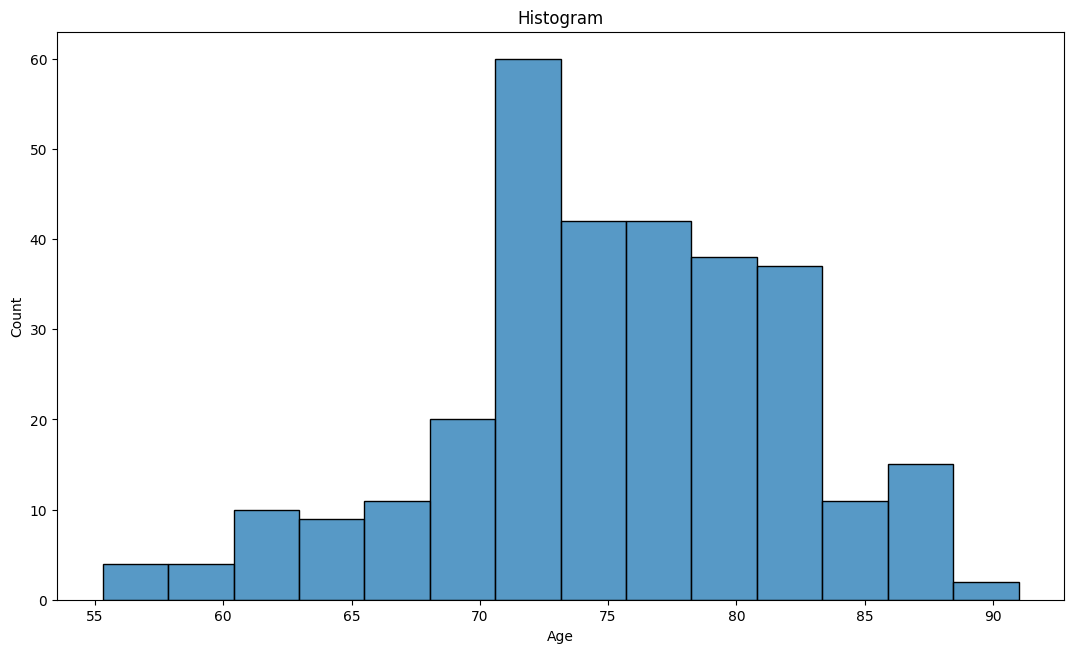

count    305.000000
mean      75.171148
std        6.675866
min       55.300000
25%       71.300000
50%       75.000000
75%       79.900000
max       91.000000
Name: Age, dtype: float64


In [19]:
numerical_exploration(train_df)

In [20]:
def categorical_exploration(df):
    """
    Transition description:
    CN - Cognitive Normal, estado normal
    MCI - Mild Cognitive Impairment, estado entre o avanço normal da perda de memoria com a idade e um certo declinio serio de demencia
    AD - Azlheimer Disease, forma mais comum de demencia nas pessoas mais velhas
    """
    categorical_df = df[["Sex","Transition"]]

    for column in categorical_df.columns:
        show_histogram(categorical_df[column],title=f"{column} histogram")
        print(df[column].value_counts())

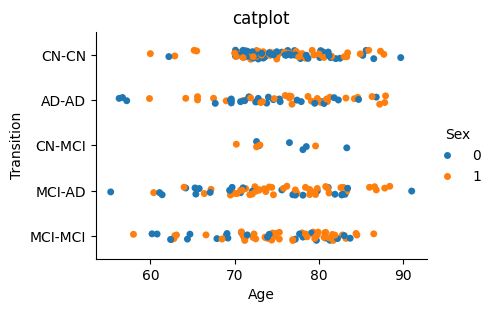

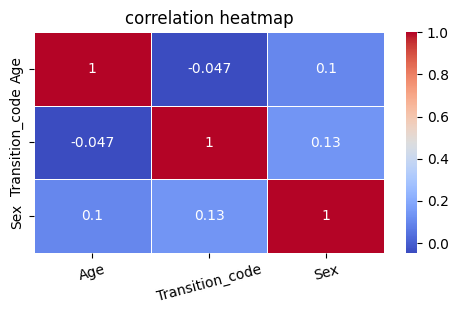

In [21]:
show_catplot(train_df, "Age", "Transition", hue="Sex")
show_heatmap(train_df[["Age","Transition_code","Sex"]])

In [22]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]
def diagnostics_configs(df):
    for col in diagnostics_configs_columns:
        print(len(df[col].unique()))

In [23]:
diagnostics_configs(train_df)

1
1


In [24]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 
def diagnostics_versions_explorer(df):
    for column in diagnostics_versions_columns:
        print(column,": ")
        values = df[column].unique()
        print(values)

In [25]:
diagnostics_versions_explorer(train_df)

diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']


In [26]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 

In [27]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]

In [28]:
unnecessary_columns = diagnostics_versions_columns + diagnostics_configs_columns +["diagnostics_Image-original_Dimensionality","diagnostics_Image-original_Minimum","diagnostics_Image-original_Size","diagnostics_Mask-original_Spacing","diagnostics_Image-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Image-original_Hash","diagnostics_Mask-original_Hash","ID","Image","Mask",'diagnostics_Mask-original_CenterOfMassIndex','diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes']

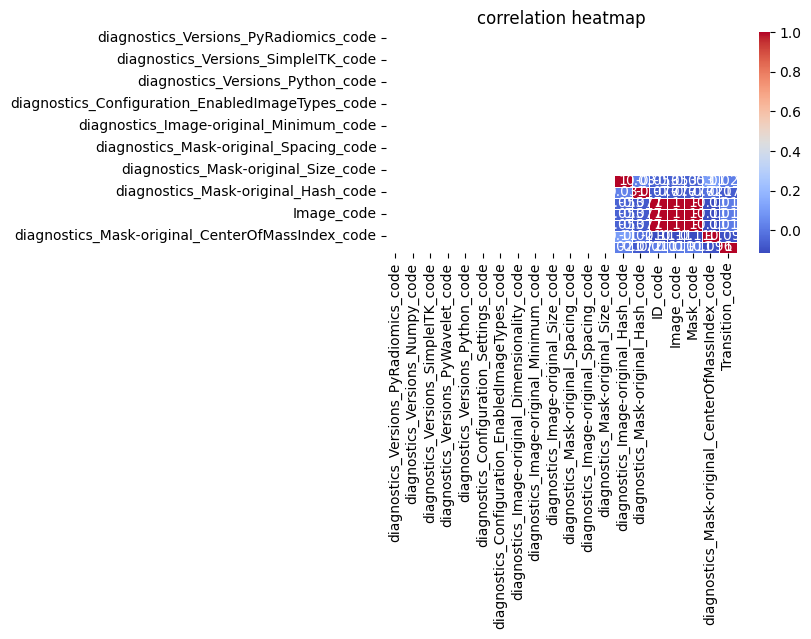

In [29]:
unnecessary_df = pd.DataFrame()
for col in unnecessary_columns+["Transition"]:
    le_make = LabelEncoder()
    unnecessary_df[f"{col}_code"] = le_make.fit_transform(train_df[col])

show_heatmap(unnecessary_df)

In [30]:
colunas_nao_numericas = train_df.select_dtypes(exclude=['number']).columns

print(train_df[colunas_nao_numericas].head())

           ID                                              Image  \
0  006_S_0681  /notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_068...   
1  941_S_1203  /notebooks/disk2/DS2_FreeSurfer/ADNI_941_S_120...   
2  011_S_0003  /notebooks/disk2/DS2_FreeSurfer/ADNI_011_S_000...   
3  057_S_0779  /notebooks/disk2/DS2_FreeSurfer/ADNI_057_S_077...   
4  033_S_0920  /notebooks/disk2/DS2_FreeSurfer/ADNI_033_S_092...   

                                                Mask  \
0  /notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_068...   
1  /notebooks/disk2/DS2_FreeSurfer/ADNI_941_S_120...   
2  /notebooks/disk2/DS2_FreeSurfer/ADNI_011_S_000...   
3  /notebooks/disk2/DS2_FreeSurfer/ADNI_057_S_077...   
4  /notebooks/disk2/DS2_FreeSurfer/ADNI_033_S_092...   

  diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                            2.2.0                     1.18.5   
1                            2.2.0                     1.18.5   
2                            2.2.0                     1.18

## Correlations

In [31]:
def top_correlations(df, target="Transition_code",starts_with=None,number=10,ascending=False):
    if starts_with == None:
        corr_columns = df.select_dtypes(include=["int64","float64"]).columns
    else:
        corr_columns = df.columns[df.columns.str.startswith(starts_with)]

    corr_matrix = df[corr_columns].corrwith(df[target])

    top_features = corr_matrix.sort_values(ascending=ascending).head(number).index.tolist()
    top_features.append(target)
    top_features = pd.Index(top_features)
    
    return top_features

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


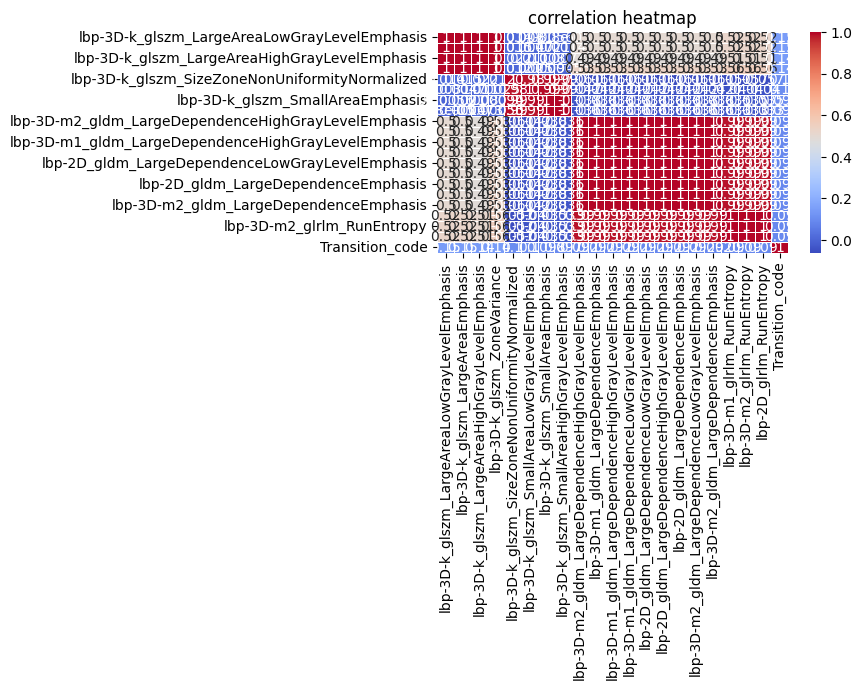

In [32]:
rad_corr = top_correlations(train_df,starts_with="lbp",number=20)
show_heatmap(train_df[rad_corr])

# Data Processing

## Drop Unnecessary Columns

In [33]:
control_df = control_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
train_df = train_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
test_df = test_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")

In [34]:
train_df[['diagnostics_Mask-original_BoundingBox']]


,diagnostics_Mask-original_BoundingBox
0,"(103, 113, 93, 36, 30, 71)"
1,"(81, 127, 93, 47, 16, 73)"
2,"(77, 119, 89, 49, 30, 81)"
3,"(93, 102, 90, 41, 29, 78)"
4,"(87, 119, 91, 40, 27, 75)"
...,...
300,"(88, 118, 89, 41, 25, 78)"
301,"(103, 103, 93, 38, 27, 70)"
302,"(80, 131, 89, 48, 17, 82)"
303,"(93, 103, 91, 40, 31, 75)"


## Non Numerical Columns

In [35]:
# Separar a coluna de BoundingBox em várias colunas
train_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = train_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
train_df[['x_center', 'y_center', 'z_center']] = train_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [36]:
# Separar a coluna de BoundingBox em várias colunas
test_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = test_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
test_df[['x_center', 'y_center', 'z_center']] = test_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [37]:
# Separar a coluna de BoundingBox em várias colunas
control_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = control_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
control_df[['x_center', 'y_center', 'z_center']] = control_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [38]:
train_df = train_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
test_df = test_df.drop(['diagnostaics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
control_df = control_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")

In [39]:
main_exploration(train_df)

(305, 2170)


In [40]:
train_df = train_df.select_dtypes(include=['number'])
control_df = control_df.select_dtypes(include=['number'])
test_df = test_df.select_dtypes(include=['number'])

## Data Scaler

In [41]:
from sklearn.preprocessing import StandardScaler

def data_scaler(df):
    scaler_df = df.drop(columns=["Transition","Transition_code"],errors="ignore")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(scaler_df),columns=scaler_df.columns)
    return df_scaled


In [42]:
scaled_train_df = data_scaler(train_df)
scaled_control_df = data_scaler(control_df)
scaled_test_df = data_scaler(test_df)

scaled_train_df["Transition_code"] = train_df["Transition_code"].values
scaled_control_df["Transition_code"] = train_df["Transition_code"].values

scaled_train_df.shape

(305, 2169)

## Correlation Analisys

In [43]:
corr_df = scaled_train_df.copy()
corr_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
target = "Transition_code"

In [44]:
corr_threshold_target = 0.01
corr_threshold_features = 0.95

def apply_correlation(df, threshold_target, threshold_features):
    # Remove a coluna "Transition" se existir
    df = df.drop(columns=["Transition"], errors="ignore")
    
    # Calcula a correlação com o target
    correlation_with_target = df.corr()[target].abs()
    important_features = correlation_with_target[correlation_with_target > threshold_target].index.tolist()
    
    if target in important_features:
        important_features.remove(target)
    
    # Remove features que são muito correlacionadas entre si
    correlation_matrix = df[important_features].corr().abs()
    selected_features = important_features.copy()
    
    for i, feature in enumerate(important_features):
        for other_feature in important_features[i+1:]:
            if correlation_matrix.loc[feature, other_feature] > threshold_features:
                if other_feature in selected_features:
                    selected_features.remove(other_feature)
    
    return selected_features


In [45]:
important_features = apply_correlation(scaled_train_df, corr_threshold_target, corr_threshold_features)
print(len(important_features))

812


In [46]:
corr_train_df = scaled_train_df[important_features]
corr_control_df = scaled_control_df[important_features]
corr_test_df = scaled_test_df[important_features]
corr_train_df.shape

(305, 812)

In [47]:
corr_train_df["Transition_code"] = train_df["Transition_code"].values
corr_control_df["Transition_code"] = train_df["Transition_code"].values

/var/folders/mw/3tkw6q2j7wn1mq2731n0bv_40000gn/T/ipykernel_2926/3502452529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_train_df["Transition_code"] = train_df["Transition_code"].values
/var/folders/mw/3tkw6q2j7wn1mq2731n0bv_40000gn/T/ipykernel_2926/3502452529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_control_df["Transition_code"] = train_df["Transition_code"].values


In [48]:
main_exploration(corr_train_df)
main_exploration(corr_control_df)
main_exploration(corr_test_df)

(305, 813)
(305, 813)
(100, 812)


# Testing Phase

In [49]:
def define_X_y(train_df, test_df = pd.DataFrame(),random_state=27):
    if test_df.empty:
        X = train_df.drop(columns=["Transition_code","Transition"],errors="ignore")
        y = train_df["Transition_code"]

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15,stratify=y,random_state=random_state)

        return x_train, x_test, y_train, y_test

    else:
        x_train = train_df.drop("Transition_code",axis=1,errors="ignore")
        y_train = train_df["Transition_code"]
        x_test = test_df

        return x_train, x_test, y_train, None

In [50]:
results = {}
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)
main_exploration(x_train)
main_exploration(x_test)

scorer = make_scorer(f1_score, average='macro')

(259, 812)
(46, 812)


## Params

In [51]:
total_samples = len(x_train)

class_counts = np.bincount(y_train)

scale_pos_weight = total_samples / class_counts

weights = {i:w for i,w in enumerate(scale_pos_weight)}

sample_class_weights = {i: total_samples / count for i,count in enumerate(class_counts)}
sample_weights = np.array([sample_class_weights[label] for label in y_train])

### Grid Params

In [52]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 5],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}


param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [2, 3, 5],
    'objective': ['multi:softprob']
}


param_grid_light = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 30, 40],
    'max_depth': [3, 5, 10, 15],
    'min_data_in_leaf': [10, 20, 30],
    'bagging_fraction': [0.5, 0.7, 0.8, 1.0],
    'objective': ['multiclassova'],
}


param_grid_svm = {
    'C': [0.1, 0.5, 1, 2, 5, 7, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf'],
    'class_weight': ['balanced'],
    'probability': [True]
}

param_grid_log = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500],
    'class_weight': ['balanced'],
    'multi_class': ['ovr', 'multinomial'],
    'tol': [1e-4, 1e-3]
}

### Bayes Params

In [53]:
param_baye_rf = {
    'n_estimators': (100, 300),
    'max_depth': (5, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'bootstrap': (0, 1),
    'class_weight': (0, 1),
}


param_baye_xgb = {
    'learning_rate': (0.01, 0.15),
    'n_estimators': (100, 300),
    'max_depth': (5, 20),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'min_child_weight': (1, 15),
}

param_baye_light = {
    'learning_rate': (0.01, 0.2),
    'num_leaves': (20, 50),
    'max_depth': (5, 15),
    'min_data_in_leaf': (10, 30),
    'bagging_fraction': (0.5, 1.0)
}


param_baye_svm = {
    'C': (1, 100),
    'gamma': (0.01, 1),
    'kernel': (0, 1),
    'class_weight': (0, 1),
    'degree': (2, 4),
    'tol': (1e-4, 1e-3)
}

param_baye_log = {
    'C': (0.01, 10),
    'max_iter': (300, 1500),
    'solver': (0,2)  # Selecione os solvers compatíveis com os dados.
}

## Models

### SVM

In [54]:
def svm_train_model(x_train,y_train):
    model = SVC(random_state=27,class_weight="balanced", probability=True)
    model.fit(x_train,y_train)

    return model

# Grid Model
def svm_grid_train_model(x_train,y_train, param_grid=param_grid_svm):
    model = SVC(random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid, cv=cv, n_iter=1000,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

def objective_svm(C, gamma, kernel, class_weight, degree, tol):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)
    
    params = {
        'C': C,
        'gamma': 'scale' if round(gamma) == 0 else gamma,  # 'scale' ou um valor float de gamma
        'kernel': 'linear' if round(kernel) == 0 else 'rbf',  # 'linear' ou 'rbf'
        'class_weight': None if round(class_weight) == 0 else 'balanced',
        'degree': int(degree) if round(kernel) == 1 else 3,  # Degree apenas para kernel polinomial
        'tol': tol,
        'random_state': 27
    }
    
    model = SVC(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy').mean()  # Troque "scorer" por "accuracy"
    return score

def svm_baye_train_model(x_train, y_train, param_baye=param_baye_svm):
    svm_bo = BayesianOptimization(
        f=objective_svm,
        pbounds=param_baye,
        random_state=27,
    )
    
    svm_bo.maximize(init_points=7, n_iter=25)

    best_params = svm_bo.max['params']

    gamma = 'scale' if round(best_params["gamma"]) == 0 else best_params["gamma"]
    kernel = 'linear' if round(best_params["kernel"]) == 0 else 'rbf'
    best_params_updated = {
        'C': best_params['C'],
        'gamma': gamma,
        'kernel': kernel,
        'class_weight': None if round(best_params['class_weight']) == 0 else 'balanced',
        'degree': int(best_params['degree']) if kernel == 'rbf' else 3,  # Degree só para kernel 'rbf'
        'tol': best_params['tol'],
        'random_state': 27
    }

    print(best_params_updated)

    model = SVC(**best_params_updated)
    model.fit(x_train, y_train)

    svm_results = pd.DataFrame(svm_bo.res)
    svm_results.sort_values(by="target", ascending=False, inplace=True)

    return model, svm_results, svm_bo.max

### RandomForest

In [55]:
# Basic Model
def random_forest_model(x_train,y_train):
    model = RandomForestClassifier(random_state=27,class_weight= 'balanced_subsample')
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def random_forest_grid_model(x_train,y_train, param_grid_rf=param_grid_rf):
    model = RandomForestClassifier(random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=27)
    
    grid_search = RandomizedSearchCV(model, param_grid_rf, cv=cv, n_iter=1000,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

#Bayes Model
def objective_random_forest(n_estimators, max_depth, min_samples_split, min_samples_leaf,bootstrap,class_weight):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=27)
    
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'bootstrap': bool(round(bootstrap)),
        'class_weight': None if round(class_weight) == 0 else 'balanced',
        'random_state': 27
    }
    
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score

def random_forest_baye_model(x_train,y_train, param_baye=param_baye_rf):
    rf_bo = BayesianOptimization(
        f=objective_random_forest,
        pbounds=param_baye,
        random_state=27,
    )
    
    rf_bo.maximize(init_points=7, n_iter=25)

    best_params = rf_bo.max['params']
    bootstrap = bool(round(best_params["bootstrap"]))
    best_params_updated = {
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),
        'min_samples_split': int(best_params['min_samples_split']),
        'min_samples_leaf': int(best_params['min_samples_leaf']),
        'bootstrap': bootstrap,
        'class_weight': None if round(best_params['class_weight']) == 0 else 'balanced',
        'random_state': 27
    }

    print(best_params_updated)

    model = RandomForestClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    rf_results = pd.DataFrame(rf_bo.res)
    rf_results.sort_values(by="target",ascending=False,inplace=True)

    return model, rf_results, rf_bo.max

### XGBoost

In [56]:
# Basic Model
def xgboost_model(x_train,y_train):
    model = XGBClassifier(random_state=27,objective= 'multi:softprob')
    model.fit(x_train,y_train, sample_weight=sample_weights)

    return model

# Grid Model
def xgboost_grid_model(x_train,y_train, param_grid_xgb=param_grid_xgb):
    model = XGBClassifier(random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid_xgb, cv=cv, n_iter=1000,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)
    

    return grid_search.best_estimator_

# Baye Model
def objective_xgboost(learning_rate, n_estimators, max_depth, subsample, colsample_bytree,min_child_weight):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight,
        'random_state': 27
    }
    
    model = XGBClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score
    
def xgboost_baye_model(x_train,y_train, param_baye=param_baye_xgb):
    xgb_bo = BayesianOptimization(
    f=objective_xgboost,
    pbounds=param_baye,
    random_state=27,
    )
    
    xgb_bo.maximize(init_points=7, n_iter=25)

    best_params = xgb_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']), 
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'min_child_weight': best_params['min_child_weight'],
        'random_state': 27
    }

    print(best_params_updated)
    
    model = XGBClassifier(**best_params_updated)
    model.fit(x_train,y_train, sample_weight=sample_weights)

    xgb_results = pd.DataFrame(xgb_bo.res)
    xgb_results.sort_values(by="target",ascending=False,inplace=True)

    return model, xgb_results, xgb_bo.max

### LightGBM

In [57]:
# Basic Model
def light_boost_model(x_train,y_train):
    model =  lgb.LGBMClassifier(verbose=-1,objective='multiclassova',class_weight=weights)
    model.fit(x_train,y_train)

    return model

# Grid Model
def light_grid_train_model(x_train,y_train, param_grid=param_grid_light):
    model = lgb.LGBMClassifier(verbose=-1,random_state=27,class_weight=weights)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid_light, cv=cv, n_iter=1000,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

# Bayes Model
def objective_light_boost(learning_rate, num_leaves, max_depth, min_data_in_leaf, bagging_fraction):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        'bagging_fraction': bagging_fraction,
        'boosting_type': 'gbdt',
        'objective': 'multiclassova', 
        'num_class': 5,
        'is_unbalance': True,
        'n_jobs': -1,
        'random_state': 27,
        'class_weight': weights,
        'verbose': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def light_baye_train_model(x_train, y_train, param_baye=param_baye_light):
    light_bo = BayesianOptimization(
        f=objective_light_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    light_bo.maximize(init_points=7, n_iter=20)

    best_params = light_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'num_leaves': int(best_params['num_leaves']),
        'max_depth': int(best_params['max_depth']),
        'min_data_in_leaf': int(best_params['min_data_in_leaf']),
        'bagging_fraction': best_params['bagging_fraction'],
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'is_unbalance': True,
        'n_jobs': -1,
        'random_state': 27,
        'verbose': -1
    }

    print(best_params_updated)
    
    model = lgb.LGBMClassifier(**best_params_updated)
    model.fit(x_train, y_train)

    light_results = pd.DataFrame(light_bo.res)
    light_results.sort_values(by="target", ascending=False, inplace=True)

    return model, light_results, light_bo.max

### Logistic Regression

In [58]:
# Basic Model
def log_reg_model(x_train,y_train):
    model = LogisticRegression(max_iter=1000,random_state=27)
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def log_grid_train_model(x_train,y_train, param_grid=param_grid_log):
    model = LogisticRegression(random_state=27, verbose=0)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid, cv=cv, n_iter=1000,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

# Função de objetivo para otimização bayesiana
def objective_logistic_regression(C, max_iter, solver):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=27)

    solvers = ['lbfgs', 'liblinear', 'saga']
    solver = solvers[int(round(solver))]  # Converte o índice numérico de volta para string


    params = {
        'C': C,
        'max_iter': int(max_iter),
        'solver': solver,
        'random_state': 27,
        'verbose': 0
    }

    model = LogisticRegression(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score

# Função principal para regressão logística com BayesOpt
def log_baye_train_model(x_train, y_train, param_baye=param_baye_log):
    log_bo = BayesianOptimization(
        f=objective_logistic_regression,
        pbounds=param_baye,
        random_state=27,
    )
    
    log_bo.maximize(init_points=5, n_iter=25)

    best_params = log_bo.max['params']

    # Mapeando o índice numérico de volta para o solver real
    solvers = ['lbfgs', 'liblinear', 'saga']
    best_solver = solvers[int(round(best_params['solver']))]  # Converte índice para string

    best_params_updated = {
        'C': best_params['C'],
        'max_iter': int(best_params['max_iter']),
        'solver': best_solver,  # Usa o nome do solver mapeado
        'random_state': 27,
        'verbose': 0
    }

    print(best_params_updated)

    model = LogisticRegression(**best_params_updated)
    model.fit(x_train, y_train)

    # Criar DataFrame com resultados da otimização
    log_results = pd.DataFrame(log_bo.res)
    log_results.sort_values(by="target", ascending=False, inplace=True)

    return model, log_results, log_bo.max

### GradientBoost

In [59]:
# Basic Model
def gradient_boost_model(x_train, y_train):
    model = GradientBoostingClassifier(random_state=27)
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def gradient_grid_model(x_train,y_train, param_grid_gb):
    model = GradientBoostingClassifier(random_state=27)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=27)

    grid_search_gb = GridSearchCV(model, param_grid_gb, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search_gb.fit(x_train,y_train)
    print(grid_search_gb.best_params_)

    return grid_search_gb.best_estimator_


# Baye Model
def objective_gradient_boost(learning_rate, n_estimators, max_depth, subsample,min_samples_split,min_samples_leaf):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'random_state': 27
    }
    
    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def gradient_baye_model(x_train,y_train, param_baye):
    gb_bo = BayesianOptimization(
        f=objective_gradient_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    gb_bo.maximize(init_points=7, n_iter=70)

    best_params = gb_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),  
        'subsample': best_params['subsample'],
        'min_samples_split': int(best_params['min_samples_split']), 
        'min_samples_leaf': int(best_params['min_samples_leaf']), 
        'random_state': 27 
    }

    print(best_params_updated)
    
    model = GradientBoostingClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    gb_results = pd.DataFrame(gb_bo.res)
    gb_results.sort_values(by="target",ascending=False,inplace=True)

    return model, gb_results, gb_bo.max

### CatBoosting

In [60]:
# Basic Model
def cat_boost_model(x_train,y_train):
    model = CatBoostClassifier(verbose=False, task_type="GPU")
    model.fit(x_train,y_train)

    return model

# Bayes Model
def objective_cat_boost(learning_rate, iterations, depth, l2_leaf_reg, border_count):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'iterations': int(iterations),
        'depth': int(depth),
        'l2_leaf_reg': l2_leaf_reg,
        'border_count': int(border_count),
        'task_type': 'GPU',
        'random_seed': 27,
        'verbose': 0
    }
    
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def cat_baye_model(x_train, y_train, param_baye):
    cat_bo = BayesianOptimization(
        f=objective_cat_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    cat_bo.maximize(init_points=5, n_iter=20)


    best_params = cat_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'iterations': int(best_params['iterations']),
        'depth': int(best_params['depth']),
        'l2_leaf_reg': best_params['l2_leaf_reg'],
        'border_count': int(best_params['border_count']),
        'task_type': 'GPU',
        'random_seed': 27,
        'verbose': 0
    }

    print(best_params_updated)
    

    model = CatBoostClassifier(**best_params_updated)
    model.fit(x_train, y_train)


    cat_results = pd.DataFrame(cat_bo.res)
    cat_results.sort_values(by="target", ascending=False, inplace=True)

    return model, cat_results, cat_bo.max

### Voting Ensemble

In [61]:
def voting_ensemble(x_train,y_train,estimators):
    model = VotingClassifier(estimators=estimators, voting="hard")
    model.fit(x_train,y_train)
    
    return model

### Stacking Ensemble

In [62]:
def stacking_ensemble(x_train,y_train,estimators):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
    
    model = StackingClassifier(
        estimators=estimators, 
        final_estimator=LogisticRegression(class_weight="balanced",n_jobs=-1,max_iter=3000,verbose=0,random_state=27), 
        cv=cv, 
        n_jobs=-1,
    )
    
    model.fit(x_train,y_train)
    
    return model

## Models Applier

In [63]:
def apply_basic_models(x_train,y_train,x_test,y_test,n_repeats=4, title="Models Macro F1 Comparison", rf=1, xgb=1, gradient=0, cat=0, log=1, light=1,svm=1):
        
    if rf:
        rf_model = random_forest_model(x_train,y_train)
        results["RandomForest"] = [rf_model,None]
    else:
        rf_model = None

    if xgb:
        xgb_model = xgboost_model(x_train,y_train)
        results["XGBoost"] = [xgb_model,None]
    else:
        xgb_model = None
        
    if gradient:
        gradient_model = gradient_boost_model(x_train,y_train)
        results["GradientBoost"] = [gradient_model,None]
    else:
        gradient_model = None
        
    if cat:
        cat_model = cat_boost_model(x_train,y_train)
        results["CatBoost"] = [cat_model,None]
    else:
        cat_model = None
        
    if log:
        log_model = log_reg_model(x_train,y_train)
        results["Logistic"] = [log_model,None]
    else:
        log_model = None      

    if light:
        light_model = light_boost_model(x_train,y_train)
        results["LightGBM"] = [light_model,None]
    else:
        light_model = None  

    if svm:
        svm_model = svm_train_model(x_train,y_train)
        results["SVM"] = [svm_model,None]
    else:
        svm_model = None 

    models_comparison(results,title,x_train=x_train,y_train=y_train,n_repeats=n_repeats)

    return rf_model, xgb_model, gradient_model, cat_model, log_model, light_model, svm_model

## Models Comparison

In [64]:
def models_comparison(results, title, x_train, y_train,n_repeats=2):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=27)
    
    for result in results:
        if results[result][1] is None:
            # Calcular F1 Score usando cross-validation
            f1_scores = cross_val_score(
                results[result][0], x_train, y_train, cv=cv, scoring=make_scorer(f1_score, average="macro")
            )
            results[result][1] = round(f1_scores.mean(),4)
            print(f"F1 Macro Score em {result}: {results[result][1]} ± {round(f1_scores.std(),3)}")
        
        else:
            print(f"F1 Macro Score em {result}: {results[result][1]}")
        
    
    # Criar gráfico
    models_score = plt.figure(figsize=(6, 3))

    mod = list(results.keys())
    f1 = list([score[1] for score in results.values()])
    
    plt.bar(mod, f1, color="lightblue", width=0.5)
    plt.xlabel("Modelo")
    plt.ylabel("Macro F1")
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()

## MultiClass Analysis

In [159]:
def class_accuracy(model,x_test,y_test):
    conf_matrix = confusion_matrix(y_test, model.predict(x_test))
    # grafico de barras com a percentagem de acertos
    class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    class_accuracies_percentage = class_accuracies * 100  
    total_per_class = np.sum(conf_matrix, axis=1) 
    correct_per_class = np.diag(conf_matrix) 
    
    plt.figure(figsize=(7, 4))
    classes = np.unique(y_test)
    plt.bar(classes, class_accuracies_percentage, color='skyblue', alpha=0.8)
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy per Class")
    plt.ylim(0, 100) 
    

    for i, v in enumerate(class_accuracies_percentage):
        text = f"{correct_per_class[i]}/{total_per_class[i]} ({v:.1f}%)"
        plt.text(classes[i], v + 2, text, ha='center', fontsize=10)
    
    plt.show()
    
    # matriz de confusão
    
    plt.figure(figsize=(7, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predict")
    plt.ylabel("Real Values")
    plt.title("Confusion Matrix")
    plt.show()

## ROC & AUC Analysis

In [157]:
def roc_auc(models, X_test, y_test):
    # Binariza o target para multiclasse
    y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])
    n_classes = y_test_bin.shape[1]

    # Define o número de linhas e colunas para a grade de subgráficos, ajustando para o número de classes
    n_cols = 2  # Define um número fixo de colunas
    n_rows = math.ceil(n_classes / n_cols)  # Calcula o número de linhas necessárias

    # Configura os subgráficos e aumenta o tamanho da figura
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
    axs = axs.flatten()  # Achata a matriz de axs para facilitar o acesso
    
    colors = ['blue', 'green', 'red', 'purple', 'orange','yellow']  # Cores para cada modelo

    for classe in range(n_classes):
        ax = axs[classe]  # Acessa o subplot correspondente à classe

        for i, (name, model) in enumerate(models.items()):
            y_score = model.predict_proba(X_test)
            
            # Calcula a curva ROC e AUC para a classe atual e o modelo atual
            fpr, tpr, _ = roc_curve(y_test_bin[:, classe], y_score[:, classe])
            auc = roc_auc_score(y_test_bin[:, classe], y_score[:, classe])
            
            
            # Plota a curva ROC para o modelo na classe atual
            ax.plot(fpr, tpr, color=colors[i], linestyle='--', label=f'{name} {classe} (AUC = {auc:.2f})')
        
        # Linha de referência (modelo aleatório)
        ax.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')
        ax.set_title(f'Classe {classe}')
        ax.set_xlabel('Falsos Positivos (FPR)')
        
        # Apenas o primeiro gráfico precisa do rótulo do eixo Y
        if classe % n_cols == 0:
            ax.set_ylabel('Verdadeiros Positivos (TPR)')
        
        # Adiciona a legenda em cada subgráfico
        ax.legend(loc='lower right')

    # Remove subgráficos extras, caso o número de classes não preencha todos os subgráficos
    for i in range(n_classes, len(axs)):
        fig.delaxes(axs[i])
    
    # Título principal
    plt.suptitle('Curvas ROC Multiclasse Comparativas (One-vs-Rest)')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta o layout para incluir o título
    plt.show()

In [67]:
def bayes_visualization(params,bayes_results,best_hyperparameters):
    param_names = list(params.keys())

    cols = 3
    rows = math.ceil(len(param_names)/cols)
    
    fig, axes = plt.subplots(rows,cols,figsize=(4*cols,4*rows))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, param in enumerate(param_names):
        if param != "target":
            ax = axes[i//3, i%3]
            ax.plot(bayes_results['params'].apply(lambda x: x[param]),
                bayes_results['target'], 'bo-', lw=1, markersize=4)
            ax.set_title(f'Optimization of {param}')
            ax.set_xlabel(param)
            ax.set_ylabel('F1 Macro Score')
     
            best_value = best_hyperparameters['params'][param]
            ax.plot(best_value, best_hyperparameters['target'], 'yo', markersize=6)
            
    for i in range(len(param_names), 6):
        fig.delaxes(axes.flatten()[i])
 
    plt.show()

## Final Predict

In [182]:
def final_score(model,x_train,y_train,x_test,y_test,models):
    model.fit(x_train,y_train)

    preds = model.predict(x_test)
    f1_per_class = f1_score(y_test, preds, average=None)
    f1_macro = f1_score(y_test, preds, average="macro")

    print("score per classe: ",f1_per_class)
    print("f1 macro: ",f1_macro)
    roc_auc(models,x_test,y_test)
    class_accuracy(model,x_test,y_test)

# Models Tester

In [68]:
rf_model,xgb_model,gradient_model,cat_model, log_model,light_model, svm_model = apply_basic_models(x_train,y_train,x_test,y_test,n_repeats=3)

KeyboardInterrupt: 

In [ ]:
stacking_model = stacking_ensemble(x_train,y_train,[("rf",rf_model),("xgb",xgb_model),("light",light_model)])
results["StackingBasicSVM"] = [stacking_model,None]
stacking_model_svm = stacking_ensemble(x_train,y_train,[("svm",svm_model),("rf",rf_model),("xgb",xgb_model),("light",light_model)])
results["StackingBasicSVM"] = [stacking_model_svm,None]
stacking_model_log = stacking_ensemble(x_train,y_train,[("log",log_model),("svm",svm_model),("rf",rf_model),("xgb",xgb_model),("light",light_model)])
results["StackingBasicLog"] = [stacking_model_log,None]

models_comparison(results,"Ensemble",x_train=x_train,y_train=y_train,n_repeats=3)

In [ ]:
class_accuracy_cv(stacking_model_log,x_train,y_train)

## Bayesian Optimization

In [ ]:
#results = {}

#rf_baye_model, rf_baye_results, best_params = random_forest_baye_model(x_train,y_train)
#results["RandomForestBaye"] = [rf_baye_model,None]
#bayes_visualization(param_baye_rf, rf_baye_results, best_params)
#models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

xgb_baye_model, xgb_baye_results, best_params = xgboost_baye_model(x_train,y_train)
results["XGBoostBaye"] = [xgb_baye_model,None]
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

light_baye_model, light_baye_results, best_params = light_baye_train_model(x_train,y_train)
results["LightBoostBaye"] = [light_baye_model,None]
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)


log_baye_model, log_baye_results, best_params = log_baye_train_model(x_train,y_train)
results["LogBaye"] = [log_baye_model,None]
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

In [ ]:
save_stuff(rf_baye_model, f"Models/rf_baye_model_{str(round(results['RandomForestBaye'][1], 2)).replace('.', '_')}.pkl")
save_stuff(xgb_baye_model, f"Models/xgb_baye_model_{str(round(results['XGBoostBaye'][1], 2)).replace('.', '_')}.pkl")
save_stuff(light_baye_model, f"Models/light_baye_model_{str(round(results['LightBoostBaye'][1], 2)).replace('.', '_')}.pkl")
save_stuff(log_baye_model, f"Models/log_baye_model_{str(round(results['LogBaye'][1], 2)).replace('.', '_')}.pkl")

"""
rf_baye_model = load_stuff(f"Models/rf_baye_model_0_35.pkl")
xgb_baye_model = load_stuff(f"Models/xgb_baye_model_0_35.pkl")
light_baye_model = load_stuff(f"Models/light_baye_model_0_38.pkl")
svm_baye_model = load_stuff(f"Models/svm_baye_model_0_31.pkl")
log_baye_model = load_stuff(f"Models/log_baye_model_0_32.pkl")
"""

In [ ]:
rf_baye_model = RandomForestClassifier(**rf_baye_model.get_params())
xgb_baye_model = XGBClassifier(**xgb_baye_model.get_params())
light_baye_model = lgb.LGBMClassifier(**light_baye_model.get_params())
svm_baye_model = SVC(**svm_baye_model.get_params())
log_baye_model = LogisticRegression(**log_baye_model.get_params())

In [ ]:
stacking_model_log = stacking_ensemble(x_train,y_train,[("log",log_baye_model),("svm",svm_baye_model),("rf",rf_baye_model),("xgb",xgb_baye_model),("light",light_baye_model)])
results["StackingBayeLog"] = [stacking_model_log,None]

models_comparison(results,"BayeEnsemble",x_train=x_train,y_train=y_train,n_repeats=4)

In [ ]:
class_accuracy_cv(stacking_model_log,x_train,y_train)

# SHAP Analysis

In [70]:
X_shap_init = x_train  # Features
y_shap_init = y_train

X_shap_init.shape

(259, 812)

In [ ]:
rf_baye_model.fit(X_shap_init, y_shap_init)
xgb_baye_model.fit(X_shap_init, y_shap_init)
light_baye_model.fit(X_shap_init, y_shap_init)
log_baye_model.fit(X_shap_init, y_shap_init)

explainer = shap.TreeExplainer(rf_baye_model,X_shap_init)
shap_values_rf = explainer(X_shap_init,check_additivity=False)
explainer = shap.TreeExplainer(xgb_baye_model,X_shap_init)
shap_values_xgb = explainer(X_shap_init,check_additivity=False)
explainer = shap.TreeExplainer(light_baye_model,X_shap_init)
shap_values_light = explainer(X_shap_init,check_additivity=False)
explainer = shap.LinearExplainer(log_baye_model,X_shap_init)
shap_values_log = explainer(X_shap_init)

In [198]:
"""
save_stuff(shap_values_rf,"SHAP_Values/shap_values_rf.pkl")
save_stuff(shap_values_xgb,"SHAP_Values/shap_values_xgb.pkl")
save_stuff(shap_values_light,"SHAP_Values/shap_values_light.pkl")
save_stuff(shap_values_log,"SHAP_Values/shap_values_log.pkl")
"""
shap_values_rf = load_stuff("SHAP_Values/shap_values_rf.pkl")
shap_values_xgb = load_stuff("SHAP_Values/shap_values_xgb.pkl")
shap_values_light = load_stuff("SHAP_Values/shap_values_light.pkl")
shap_values_log = load_stuff("SHAP_Values/shap_values_log.pkl")

## Deep SHAP Analysis

### Methods

In [199]:
def get_global_shap_info_df(shap_values_list, X):
    all_shap_values = []

    for shap_values in shap_values_list:
        if hasattr(shap_values, 'values'):
            shap_array = shap_values.values
        else:
            shap_array = shap_values 
        
        all_shap_values.append(shap_array)
    
    # Concatena todos os SHAP values dos modelos
    all_shap_values = np.concatenate(all_shap_values, axis=0)  # Concatena ao longo do eixo 0 (modelos)
    
    abs_shap_values = np.abs(all_shap_values)
    
    # Calcula a média global dos SHAP values
    feature_shap_mean = np.mean(abs_shap_values, axis=(0, 2))  # Média global dos SHAP values absolutos
    feature_shap_max = np.max(abs_shap_values, axis=(0, 2))  # Máximo global dos SHAP values absolutos
    feature_shap_std = np.std(abs_shap_values, axis=(0, 2))  # Desvio padrão global dos SHAP values absolutos
    feature_shap_positive_ratio = np.mean(all_shap_values > 0, axis=(0, 2))  # Proporção de SHAP values positivos
    feature_shap_negative_ratio = np.mean(all_shap_values < 0, axis=(0, 2))  # Proporção de SHAP values negativos
    
    # Cria o DataFrame com as importâncias e métricas adicionais
    feature_shap_importance_df = pd.DataFrame({
        "feature": X.columns,
        "importance_mean": feature_shap_mean,
        "importance_max": feature_shap_max,
        "importance_std": feature_shap_std,
        "positive_ratio": feature_shap_positive_ratio,
        "negative_ratio": feature_shap_negative_ratio
    }).sort_values(by="importance_mean", ascending=False)  # Ordena pelo valor médio global dos SHAP

    return feature_shap_importance_df


In [200]:
def get_shap_info_df(shap_values, X):
    # Verifica se shap_values é um objeto shap.Explanation ou um ndarray
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values 
    
    abs_shap_values = np.abs(shap_array)
    
    feature_shap_mean = np.mean(abs_shap_values, axis=(0, 2))  # Média dos SHAP values absolutos
    feature_shap_max = np.max(abs_shap_values, axis=(0, 2))  # Máximo dos SHAP values absolutos
    feature_shap_std = np.std(abs_shap_values, axis=(0, 2))  # Desvio padrão dos SHAP values absolutos
    feature_shap_positive_ratio = np.mean(shap_array > 0, axis=(0, 2))
    feature_shap_negative_ratio = np.mean(shap_array < 0, axis=(0, 2))

    
    # Cria o DataFrame com as importâncias e métricas adicionais
    feature_shap_importance_df = pd.DataFrame({
        "feature": X.columns,
        "importance_mean": feature_shap_mean,
        "importance_max": feature_shap_max,
        "importance_std": feature_shap_std,
        "positive_ratio": feature_shap_positive_ratio,
        "negative_ratio": feature_shap_negative_ratio
    }).sort_values(by="importance_std", ascending=False)  # Ordena pelo valor máximo de SHAP

    return feature_shap_importance_df


In [201]:
def get_shap_info_per_class(shap_values, X, name):
    # Verifica se shap_values é um objeto shap.Explanation ou um ndarray
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values 

    abs_shap_values = np.abs(shap_array)  # Valores absolutos dos SHAP values
    n_classes = shap_array.shape[2]  # Número de classes
    
    # Normaliza os valores absolutos pelo máximo global de cada classe
    max_global_per_class = np.max(abs_shap_values, axis=(0, 1))  # Máximo global por classe
    
    for class_idx in range(n_classes):
        # Extrai SHAP values para a classe atual
        class_abs_shap_values = abs_shap_values[:, :, class_idx]
        class_shap_values = shap_array[:, :, class_idx]
        
        # Calcula métricas normalizadas
        feature_shap_mean = np.mean(class_abs_shap_values, axis=0)  # Média
        feature_shap_max = np.max(class_abs_shap_values, axis=0)  # Máximo
        feature_shap_std = np.std(class_abs_shap_values, axis=0)  # Desvio padrão
        feature_shap_positive_ratio = np.mean(class_shap_values > 0, axis=0)  # Razão de valores positivos
        feature_shap_negative_ratio = np.mean(class_shap_values < 0, axis=0)  # Razão de valores negativos

        # Cria DataFrame com as informações
        class_df = pd.DataFrame({
            "feature": X.columns,
            "importance_mean": feature_shap_mean,
            "importance_max": feature_shap_max,
            "importance_std": feature_shap_std,
            "positive_ratio": feature_shap_positive_ratio,
            "negative_ratio": feature_shap_negative_ratio
        }).sort_values(by="importance_std", ascending=False)  # Ordena pelo valor médio

        # Salva em CSV
        class_df.to_csv(f"../Dataset/SHAP_Values/{name}class{class_idx}_shap_values.csv", index=False)


In [202]:
def get_discard_feature_per_class(model_name, importance_mean, ratio_thre, ratio_mean, std_thre):
    class_discard_features = []
    
    for i in range(5):
        df = pd.read_csv(f"../Dataset/SHAP_Values/{model_name}class{i}_shap_values.csv")

        discard_features = df[
            (df["importance_mean"] <= importance_mean) | 
            ((df["negative_ratio"] - df["positive_ratio"] > ratio_thre) & 
            (df["importance_mean"] < ratio_mean)) |
            (df["importance_std"] >= std_thre)
        ]["feature"].tolist()
        
        class_discard_features.append(discard_features)
        
    # Contar quantas classes descartam cada feature
    feature_counts = {}
    for discard_list in class_discard_features:
        for feature in discard_list:
            if feature not in feature_counts:
                feature_counts[feature] = 0
            feature_counts[feature] += 1
    
    # Selecionar as features que são descartadas em 3 ou mais classes
    combined_classes = [feature for feature, count in feature_counts.items() if count > 3]
    
    # Verificar quantas features serão descartadas
    print(len(combined_classes))

    return combined_classes

    

In [203]:
def new_shap_values(shap_values,discard_features):
    shap_array = shap_values.values
    feature_names = shap_values.feature_names
    
    features_a_remover = discard_features if isinstance(discard_features, list) else [discard_features]
    features_a_remover = set(features_a_remover) & set(list(feature_names))
    indices_a_remover = [feature_names.index(feature) for feature in features_a_remover]

    shap_values_filtrados = np.delete(shap_array, indices_a_remover, axis=1)
    
    features_restantes = [f for i, f in enumerate(feature_names) if i not in indices_a_remover]
    shap_values_filtrados = shap.Explanation(values=shap_values_filtrados, 
                                             base_values=shap_values_xgb.base_values, 
                                             feature_names=features_restantes)

    return shap_values_filtrados

In [204]:
def clean_shap_df(df,discard):
    shap_importances_df_cleaned = df[~df['feature'].isin(discard)]
    shap_importances_df_cleaned.to_csv("../Dataset/SHAP_Values/global_shap_values.csv",index=False)
    return shap_importances_df_cleaned

In [205]:
def sorted_shap_values(shap_values,X_shap, class_index):
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values 

    shap_class_values = shap_array[:, :, class_index]

    mean_shap_values = np.mean(np.abs(shap_class_values), axis=0)

    shap_df = pd.DataFrame(mean_shap_values, index=X_shap.columns, columns=["mean_shap_value"])

    sorted_features = shap_df.sort_values(by="mean_shap_value", ascending=False)

    return sorted_features

In [79]:
def shap_values_df_analysis(df):
    
    fig, axes = plt.subplots(4, 2, figsize=(14, 15))
    fig.suptitle("Distribuição dos Valores de Importância das Features", fontsize=16)
    
    importance_columns = df.drop(columns=["feature"]).columns
    
    for idx, col in enumerate(importance_columns):
        ax = axes[idx // 2, idx % 2]
        ax.hist(df[col], bins=30, color='teal', edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribuição de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequência')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [80]:
def show_shap_importance_summary_plot(shap_values,X_shap, classe):
    sorted_shap_values_df = sorted_shap_values(shap_values,X_shap,classe)
    sorted_columns = sorted_shap_values_df.index
    
    n_features = len(sorted_columns)
    n_features_per_plot = 10
    
    feature_indices = [X_shap.columns.get_loc(feature) for feature in sorted_columns]

    for i in range(0, n_features, n_features_per_plot):
        selected_columns = feature_indices[i:i + n_features_per_plot]

        shap.summary_plot(shap_values[:, selected_columns, classe])
        
        plt.show()

In [81]:
def show_shap_importance_heatmap(shap_values,X_shap,classe):
    sorted_shap_values_df = sorted_shap_values(shap_values,X_shap,classe)
    sorted_columns = sorted_shap_values_df.index
    
    n_features = len(sorted_columns)
    n_features_per_plot = 10
    
    feature_indices = [X_shap.columns.get_loc(feature) for feature in sorted_columns]

    for i in range(0, n_features, n_features_per_plot):
        selected_columns = feature_indices[i:i + n_features_per_plot]
        
        shap.plots.heatmap(shap_values[:, selected_columns, classe])
        
        plt.show()

### Global SHAP Values analysis

In [164]:
shap_importances_rf = pd.read_csv("../Dataset/SHAP_Values/global_shap_values_rf.csv")
shap_importances_xgb = pd.read_csv("../Dataset/SHAP_Values/global_shap_values_xgb.csv")
shap_importances_light = pd.read_csv("../Dataset/SHAP_Values/global_shap_values_light.csv")
shap_importances_log = pd.read_csv("../Dataset/SHAP_Values/global_shap_values_log.csv")

In [165]:
shap_importances_rf.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio
count,812.000000,812.000000,812.000000,812.000000,812.000000
mean,0.000405,0.004525,0.000498,0.458798,0.475063
std,0.000552,0.003788,0.000501,0.071268,0.078041
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000155,0.002471,0.000252,0.418361,0.431475
50%,0.000240,0.003420,0.000346,0.468197,0.489180
75%,0.000397,0.005278,0.000519,0.502295,0.525902
max,0.005866,0.040933,0.004594,0.695738,0.649180


In [184]:
discard_features_rf = shap_importances_rf[
        (shap_importances_rf["importance_mean"] <= 0.0003) |
        ((shap_importances_rf["positive_ratio"] <= 0.1) & (shap_importances_rf["negative_ratio"] <= 0.1)) |
        (shap_importances_rf["importance_std"] <= 0.0005)

    ]["feature"].tolist()
print("rf: ",len(discard_features_rf))

rf:  609


In [185]:
shap_importances_xgb.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio
count,812.000000,812.000000,812.000000,812.000000,812.000000
mean,0.007460,0.072975,0.013368,0.132673,0.157228
std,0.010842,0.107130,0.018754,0.110914,0.130509
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000561,0.011903,0.001928,0.022951,0.035902
50%,0.003969,0.043607,0.008096,0.123279,0.142623
75%,0.008906,0.091478,0.016231,0.206557,0.243115
max,0.080157,1.217653,0.168329,0.492459,0.558689


In [187]:
discard_features_xgb = shap_importances_xgb[
        (shap_importances_xgb["importance_mean"] <= 0.0075) |
        ((shap_importances_xgb["positive_ratio"] <= 0.1) & (shap_importances_xgb["negative_ratio"] <= 0.1)) | 
        (shap_importances_xgb["importance_std"] <= 0.01)

    ]["feature"].tolist()
print("xgb: ",len(discard_features_xgb))

xgb:  567


In [169]:
shap_importances_light.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio
count,812.000000,812.000000,812.000000,812.000000,812.000000
mean,0.009776,0.162421,0.021431,0.279142,0.300960
std,0.016082,0.265795,0.036398,0.137117,0.145457
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001769,0.036163,0.004505,0.187213,0.197705
50%,0.004614,0.080885,0.010211,0.281311,0.299016
75%,0.010459,0.168734,0.020995,0.366557,0.397541
max,0.134457,3.443917,0.412623,0.721967,0.704262


In [188]:
discard_features_light = shap_importances_light[
        (shap_importances_light["importance_mean"] <= 0.0075) |
        ((shap_importances_light["positive_ratio"] <= 0.1) & (shap_importances_light["negative_ratio"] <= 0.1)) |
        (shap_importances_light["importance_std"] <= 0.01)

    ]["feature"].tolist()
print("light: ",len(discard_features_light))

light:  527


In [189]:
shap_importances_log.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio
count,812.000000,812.000000,812.000000,812.000000,812.000000
mean,0.035971,0.377873,0.043056,0.501001,0.498999
std,0.019084,0.240735,0.022346,0.025922,0.025922
min,0.001427,0.007308,0.001342,0.375082,0.339672
25%,0.022829,0.210674,0.027295,0.489836,0.488525
50%,0.032213,0.331137,0.039458,0.500328,0.499672
75%,0.044779,0.473731,0.054686,0.511475,0.510164
max,0.143329,1.946421,0.175892,0.660328,0.624918


In [190]:
discard_features_log = shap_importances_log[
        (shap_importances_log["importance_mean"] <= 0.04) |
        ((shap_importances_log["positive_ratio"] <= 0.1) & (shap_importances_log["negative_ratio"] <= 0.1)) |
        (shap_importances_log["importance_std"] <= 0.01)
    ]["feature"].tolist()
print("log: ",len(discard_features_log))

log:  542


In [191]:
class_discard_features = [discard_features_rf, discard_features_xgb, discard_features_light, discard_features_log]

# Contar quantas classes descartam cada feature
feature_counts = {}
for discard_list in class_discard_features:
    for feature in discard_list:
        if feature not in feature_counts:
            feature_counts[feature] = 0
        feature_counts[feature] += 1

# Selecionar as features que são descartadas em 3 ou mais classes
combined_classes = [feature for feature, count in feature_counts.items() if count > 2]

# Verificar quantas features serão descartadas
print(len(combined_classes))

528


In [192]:
shap_train_df = corr_train_df.drop(columns=combined_classes)
shap_control_df = corr_control_df.drop(columns=combined_classes)
shap_test_df = corr_test_df.drop(columns=combined_classes)

# Models Tester

In [210]:
results = {}
x_train, x_test, y_train, y_test = define_X_y(corr_train_df,random_state=27)
main_exploration(x_train)
main_exploration(x_test)

(259, 812)
(46, 812)


## Basic Models

F1 Macro Score em RandomForest: 0.3223 ± 0.057
F1 Macro Score em XGBoost: 0.3195 ± 0.065
F1 Macro Score em Logistic: 0.2921 ± 0.051
F1 Macro Score em LightGBM: 0.323 ± 0.068
F1 Macro Score em SVM: 0.3117 ± 0.026


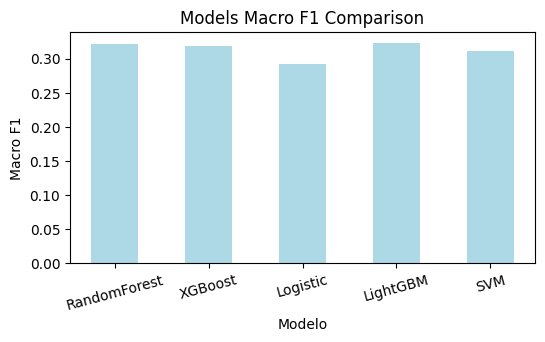

In [211]:
rf_model, xgb_model, gradient_model, cat_model, log_model, light_model,svm_model = apply_basic_models(x_train,y_train,x_test,y_test,n_repeats=3)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


F1 Macro Score em RandomForest: 0.3223
F1 Macro Score em XGBoost: 0.3195
F1 Macro Score em Logistic: 0.2921
F1 Macro Score em LightGBM: 0.323
F1 Macro Score em SVM: 0.3117


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


F1 Macro Score em StackingBasicLog: 0.3129 ± 0.036


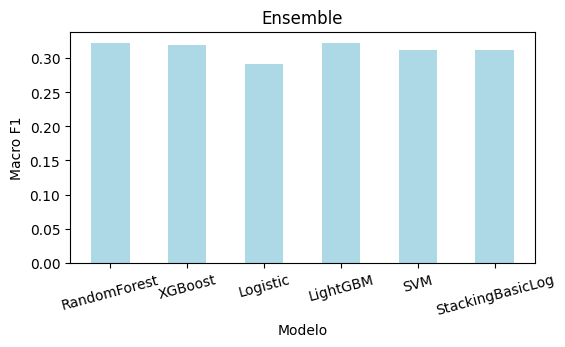

In [212]:
stacking_model_log = stacking_ensemble(x_train,y_train,[("log",log_model),("svm",svm_model),("rf",rf_model),("xgb",xgb_model),("light",light_model)])
results["StackingBasicLog"] = [stacking_model_log,None]
models_comparison(results,"Ensemble",x_train=x_train,y_train=y_train,n_repeats=3)

In [213]:
print(x_train.shape,
y_train.shape,
x_test.shape,
y_test.shape
)

(259, 812) (259,) (46, 812) (46,)


score per classe:  [0.58823529 0.69230769 0.4        0.57142857 0.43478261]
f1 macro:  0.5373508333099126


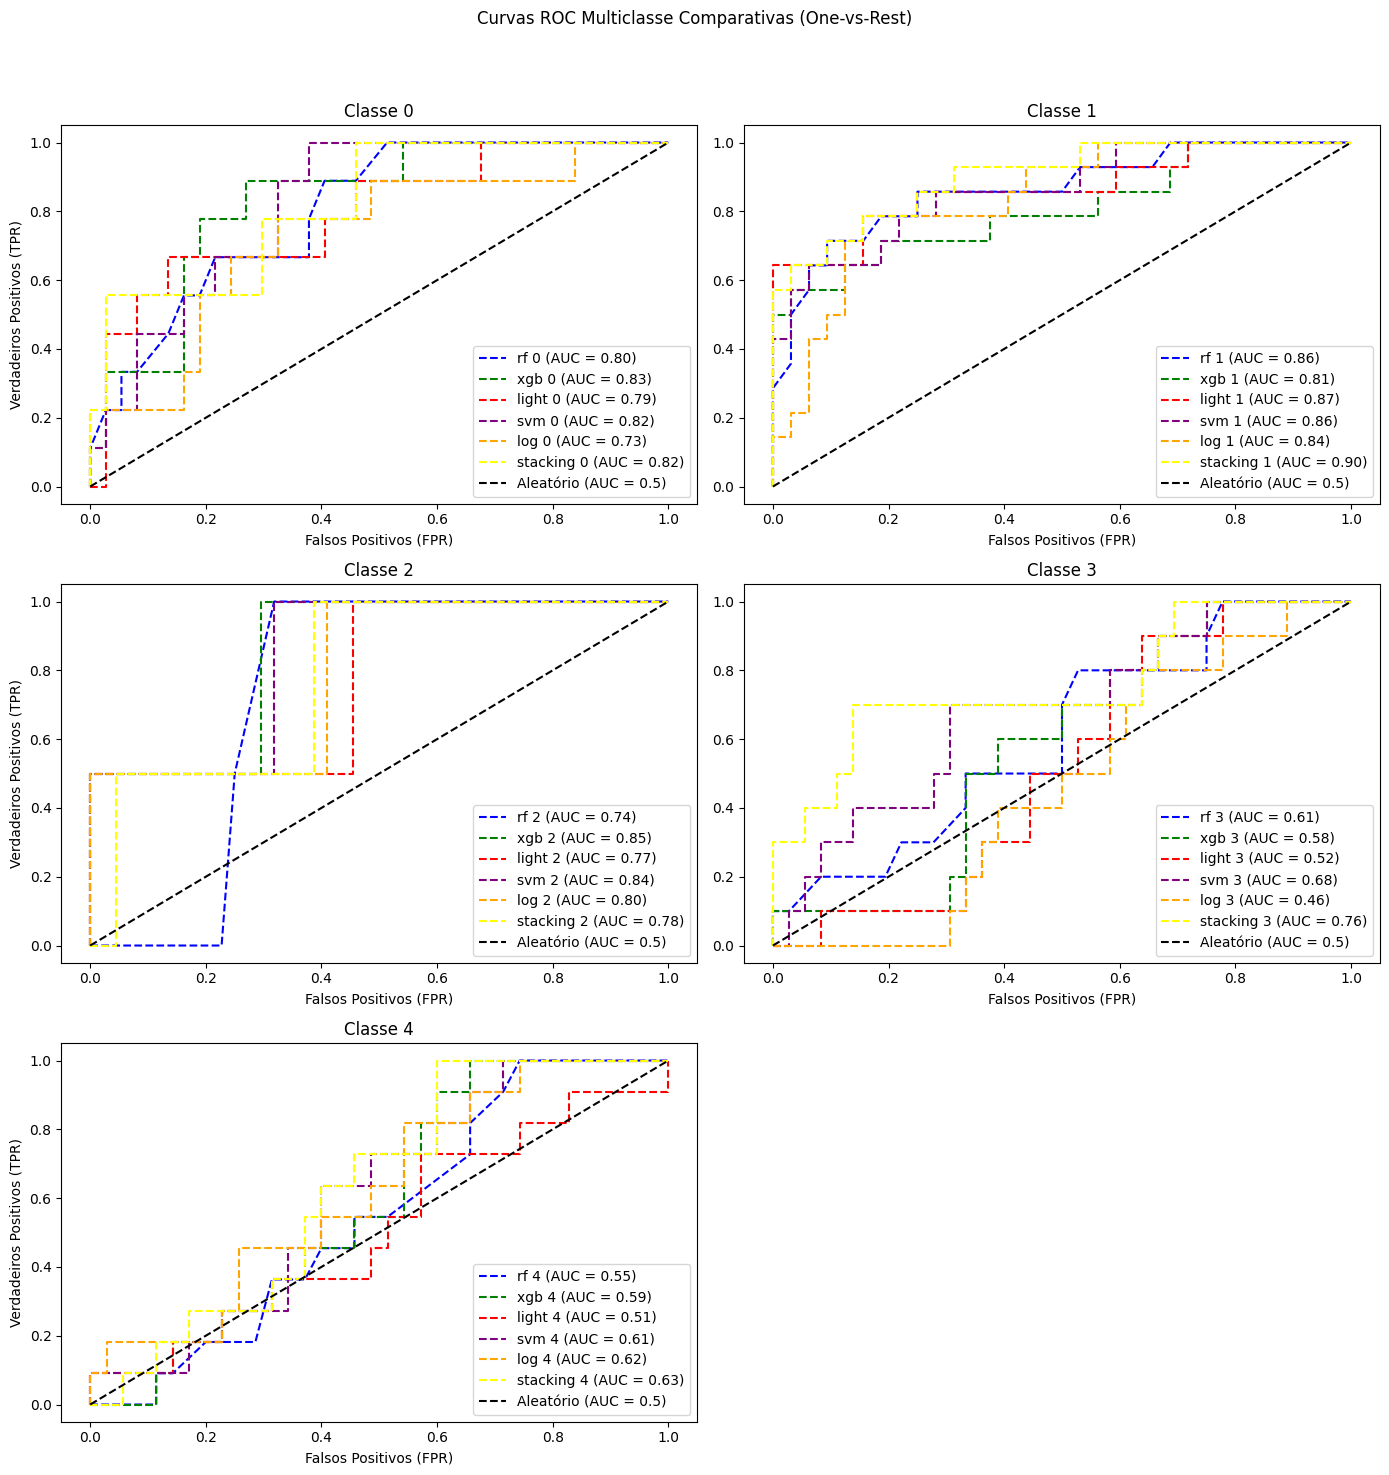

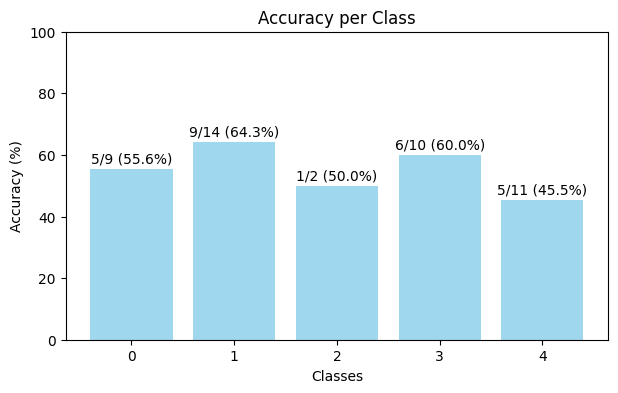

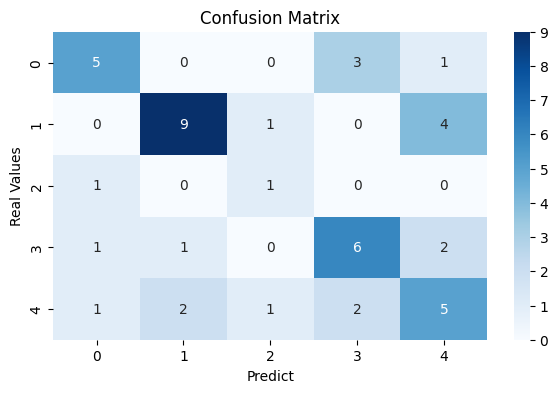

In [214]:
models = {"rf": rf_model, "xgb":xgb_model, "light": light_model, "svm":svm_model, "log":log_model,"stacking":stacking_model_log}
final_score(stacking_model_log, x_train, y_train, x_test, y_test, models)

## GridSearch Tuning

In [ ]:
results = {}
svm_grid_model = svm_grid_train_model(x_train,y_train)
results["SVMGrid"] = [svm_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

log_grid_model = log_grid_train_model(x_train,y_train)
results["LogGrid"] = [log_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

rf_grid_model = random_forest_grid_model(x_train,y_train)
results["RandomForestGrid"] = [rf_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

xgb_grid_model = xgboost_grid_model(x_train,y_train)
results["XGBoostGrid"] = [xgb_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

light_grid_model = light_grid_train_model(x_train,y_train)
results["lightGrid"] = [light_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)


In [ ]:
rf_grid_model = RandomForestClassifier(**rf_grid_model.get_params())
xgb_grid_model = XGBClassifier(**xgb_grid_model.get_params())
light_grid_model = lgb.LGBMClassifier(**light_grid_model.get_params())
svm_grid_model = SVC(**svm_grid_model.get_params())
log_grid_model = LogisticRegression(**log_grid_model.get_params())

stacking_model_log = stacking_ensemble(x_train,y_train,estimators=[("log",log_grid_model),("svm",svm_grid_model),("rf",rf_grid_model),("xgb",xgb_grid_model),("light",light_grid_model)])

results["StackingGridLog"] = [stacking_model_log,None]

models_comparison(results,"Grid Ensemble",x_train=x_train,y_train=y_train,n_repeats=5)

In [ ]:
class_accuracy_cv(log_grid_model,x_train,y_train)
class_accuracy_cv(svm_grid_model,x_train,y_train)
class_accuracy_cv(rf_grid_model,x_train,y_train)
class_accuracy_cv(xgb_grid_model,x_train,y_train)
class_accuracy_cv(light_grid_model,x_train,y_train)
class_accuracy_cv(stacking_model_log,x_train,y_train)

In [ ]:
models = {"RF": rf_model,"XGB": xgb_model,"Light":light_model,"Stacking": stacking_model_svm}
roc_auc(models,x_train, y_train, x_test, y_test)

## Ensemble with Best Models

In [ ]:
rf_best_model = RandomForestClassifier(**rf_baye_model.get_params())
xgb_best_model = XGBClassifier(**xgb_grid_model.get_params())
light_best_model = lgb.LGBMClassifier(**light_grid_model.get_params())
svm_best_model = SVC(**svm_grid_model.get_params())

stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_best_model),("xgb",xgb_best_model),("light",light_best_model)])
stacking_model_svm = stacking_ensemble(x_train,y_train,estimators=[("svm",svm_best_model),("rf",rf_best_model),("xgb",xgb_best_model),("light",light_best_model)])

results["StackingGrid"] = [stacking_model,None]
results["StackingGridSVM"] = [stacking_model_svm,None]

models_comparison(results,"Grid Ensemble",x_train=x_train,y_train=y_train,n_repeats=10)

In [ ]:
class_accuracy(stacking_model,x_test,y_test)

# Get Preds

In [ ]:
results = {}
x_train_final, x_test_final, y_train_final, y_test_final = define_X_y(shap_train_df,shap_test_df,random_state=20)
main_exploration(x_train_final)
main_exploration(x_test_final)

In [ ]:
rf_params = rf_model.get_params()
xgb_params = xgb_model.get_params()
light_params = light_model.get_params()
svm_params = svm_model.get_params()

In [ ]:
rf_grid_params = rf_grid_model.get_params()
xgb_grid_params = xgb_grid_model.get_params()
light_grid_params = light_grid_model.get_params()
svm_grid_params = svm_grid_model.get_params()
log_grid_model = log_grid_model.get_params()

In [ ]:
rf_preds_model = RandomForestClassifier(**rf_grid_params)
xgb_preds_model = XGBClassifier(**xgb_grid_params)
light_preds_model = lgb.LGBMClassifier(**light_grid_params)
svm_preds_model = SVC(**svm_grid_params)
log_grid_model = LogisticRegression(**log_grid_model)


In [ ]:
#stacking_model = stacking_ensemble(x_train_final,y_train_final,estimators=[("rf",rf_preds_model),("xgb",xgb_preds_model),("light",light_preds_model)])
#stacking_model_svm = stacking_ensemble(x_train_final,y_train_final,estimators=[("svm",svm_preds_model),("rf",rf_preds_model),("xgb",xgb_preds_model),("light",light_preds_model)])
stacking_model_log = stacking_ensemble(x_train_final,y_train_final,estimators=[("log",log_grid_model),("svm",svm_preds_model),("rf",rf_preds_model),("xgb",xgb_preds_model),("light",light_preds_model)])


## Preds to CSV

In [ ]:
def preds_to_csv(preds, df=dummy_df):
    if len(preds) == 100:
        y_pred_original = target_decoder(le_make_train, preds)
        
        df["Result"] = y_pred_original
        
        df.to_csv("../Dataset/dummy_submission.csv", index=False)

        print("CSV updated!\n", y_pred_original)
    else:
        print("Invalid input!")


In [ ]:
preds_to_csv(stacking_model_svm.predict(x_test_final))

In [ ]:
save_stuff(stacking_model_log,"Models/stacking_reduction_dos_shap_globais_thre_0_02.pkl")

In [ ]:
stacking_model